<a href="https://colab.research.google.com/github/calciver/SGCR/blob/master/SGCR_Colab_Version_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset and unzip

In [0]:
!pip install -q patool
import patoolib
import os

#Organise our files
ROOT_DIR = os.path.abspath("/content")
!git clone https://github.com/calciver/SGCR.git  
WORK_DIR = os.path.abspath("/content/SGCR")
os.chdir(WORK_DIR)


patoolib.extract_archive("train_and_val_images.zip")  
IMAGE_DIR = os.path.abspath("/content/radiology/train_and_val_images")

     |████████████████████████████████| 81kB 28.6MB/s 
Cloning into 'SGCR'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 2 (delta 0), pack-reused 36
Unpacking objects: 100% (39/39), done.
patool: Extracting train_and_val_images.zip ...
patool: running /usr/bin/7z x -o./Unpack_tb7mgq9f -- train_and_val_images.zip
patool: ... train_and_val_images.zip extracted to `train_and_val_images' (multiple files in root).


# Utils

In [0]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import csv
from keras.layers import Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense
from PIL import Image
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
import time
from numpy import random
import os
import matplotlib.pyplot as plt

#------------------------------------------Constants--------------------------------------------------------------------


ROOT_DIR = os.path.abspath("/content")
!git clone https://github.com/calciver/SGCR.git  
WORK_DIR = os.path.abspath("/content/SGCR")
os.chdir(WORK_DIR)


csv_files_dir = os.path.abspath('/content/SGCR')
train_image_file_dir = os.path.abspath('/content/SGCR/train_and_val_images/train')
val_image_file_dir = os.path.abspath('/content/SGCR/train_and_val_images/val')

os.mkdir('models')
model_directory = os.path.abspath("/content/SGCR/models")

val_csv_filename = 'val.csv'
train_csv_filename = 'train.csv'

#Number of epochs
num_epochs = 1

Using TensorFlow backend.


Cloning into 'SGCR'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 2 (delta 0), pack-reused 36
Unpacking objects: 100% (39/39), done.


# Process and Load the data

In [0]:
#--------------------------------Preparing data functions --------------------------------------------------------------

#Gets csv files directory and csv filename and returns rows in csv files which are image names and lables---------------
def load_csv (csv_files_dir, csv_filename) :
    csv_rows = []
    with open(csv_files_dir + '/' + csv_filename, newline='') as csvFile:
        reader = csv.reader(csvFile, delimiter=',')
        for row in reader:
            csv_rows.append(row)
    #print('csv_rows[-1] : ', csv_rows[-1], len(csv_rows))
    return csv_rows

#returns numpy arrays of images and labels for each batch---------------------------------------------------------------
def load_data (batch, image_dir):
    image_array = []
    label_array = []
    for b in batch:
        image_array.append(np.asarray(Image.open(image_dir + '/' + b[0])))
        label_array.append(b[1])
    labels = np.array(label_array)
    images = np.array(image_array)
    return images, labels

#-----------------------------------Preparing training data ------------------------------------------------------------

train_imagename_label_pairs = load_csv(csv_files_dir, train_csv_filename)
#shuffle images and labels foe each epoch
random.shuffle(train_imagename_label_pairs)
[train_images, train_labels ] = load_data(train_imagename_label_pairs, train_image_file_dir)

#number of training data size
batch_size_train= len(train_imagename_label_pairs)
image_shape = train_images.shape
train_images2 = np.reshape(train_images, [-1, image_shape[1], image_shape[2], 1])
train_labels1 = to_categorical(train_labels)
train_labels2 = np.reshape(train_labels1, [batch_size_train, 2])

#--------------------------------Preparing validation data--------------------------------------------------------------

val_imagename_label_pairs = load_csv(csv_files_dir, val_csv_filename)
random.shuffle(val_imagename_label_pairs)
[val_images, val_labels] = load_data(val_imagename_label_pairs, val_image_file_dir)

#number of training validation size
batch_size_val = len(val_imagename_label_pairs)
image_shape = val_images.shape
val_images2 = np.reshape(val_images, [-1, image_shape[1], image_shape[2], 1])
val_labels1 = to_categorical(val_labels)
val_labels2 = np.reshape(val_labels1, [batch_size_val, 2])


# Build the Model

In [0]:
#---------------------------------------Tensorboard Class---------------------------------------------------------------
#This class is used to merge traing accuracy and validation accuracy graphs in Tensorboard

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='/logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            if isinstance(value, np.ndarray):
                summary_value.simple_value = value.item()
            else:
                summary_value.simple_value = value
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()




#ploting 4 different categories-----------------------------------------------------------------------------------------
def show_samples(input_image , input_pairs  ,image_dir):

    correct_pneumonia=[]
    incorrect_pneumonia=[]
    correct_normal=[]
    incorrect_normal=[]
    prediction = np.empty(0)
#model.predict returns 2 valuse which are predictions of each label
    pred =model.predict(x=input_image, batch_size=None , verbose=0, steps=None)
    prediction = np.append(prediction,pred)
    prediction_list = prediction.tolist()
    zero_labels_predicted = prediction_list[::2]
    one_labels_predicted = prediction_list[1::2]

    for i in range(len(input_pairs)) :

        if input_pairs[i][1] == '1' :
            if one_labels_predicted[i] > 0.50 :
                print("correct_pneumonia : " , input_pairs[i][0])
                correct_pneumonia.append(input_pairs[i][0])
            elif one_labels_predicted[i] <0.50 :
                incorrect_pneumonia.append(input_pairs[i][0])

        elif input_pairs[i][1] == '0' :
            if zero_labels_predicted[i] > 0.50 :
                correct_normal.append(input_pairs[i][0])
                print("correct normal : ", input_pairs[i][0])
            elif zero_labels_predicted[i] < 0.50 :
                incorrect_normal.append(input_pairs[i][0])

#ploting images
    if correct_pneumonia != [] :
        plt.subplot(2, 2, 1)
        img = plt.imread(image_dir +'/' + correct_pneumonia[0])
        plt.imshow(img, cmap='gray')
        plt.title('correct_pneumonia')

    if incorrect_pneumonia != [] :
        plt.subplot(2, 2, 2)
        img = Image.open(image_dir + '/' + incorrect_pneumonia[0])
        plt.imshow(img, cmap='gray')
        plt.title('incorrect_pneumonia')

    if correct_normal !=[] :
        plt.subplot(2, 2, 3)
        img = Image.open(image_dir + '/' + correct_normal[0])
        plt.imshow(img, cmap='gray')
        plt.title('correct_normal')

    if incorrect_normal != [] :
        plt.subplot(2, 2, 4)
        img = Image.open(image_dir + '/' + incorrect_normal[0])
        plt.imshow(img, cmap='gray')
        plt.title('incorrect_normal')

    plt.show()


#saving model-----------------------------------------------------------------------------------------------------------
def save_model(model):
    # serialize model to JSON
    model_json =  model.to_json()

    #model_directory = "/home/mashids/PycharmProjects/data_processing/save_model_/"
    if not os.path.exists(model_directory):
        os.mkdir(model_directory)

    model_filename_json =  model_directory+Name+ ".json"
    print(model_filename_json)

    model_filename_h5 = model_directory +Name+ ".h5"

    with open(model_filename_json, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_filename_h5)
    print("Saved model to disk")



#-----------------------------------Model Architecture------------------------------------------------------------------

Name = 'updated_model-{}'.format(int(time.time()))
tensorboard = TrainValTensorBoard(log_dir='logs/{}'.format(Name))

#set up a sequential model
model = Sequential()
#first convolutional layer with 8 channels and kenel size of 7*7
model.add(Conv2D(8, (7, 7), input_shape=(512, 512, 1), kernel_initializer="glorot_normal"))
# tanh activation function
model.add(Activation('tanh'))
#polling layer using Maxpooling of window size 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (4, 4), kernel_initializer="glorot_normal"))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(32, (3, 3), kernel_initializer="glorot_normal"))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(64, kernel_initializer="glorot_normal"))
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(32, kernel_initializer="glorot_normal"))
model.add(Activation('tanh'))

model.add(Dense(2))
model.add(Activation('softmax'))

#Summarize Model and Visualize Model
model.summary()

#Configures the model for training using  existing loss function 'categorical_crossnetropy' .
#'Adam' optimizer with learning rate of 0.0005.
#and 'categorical_accuracy' as metrices to be evaluated by the model during training and testing.
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, decay=0.00001, amsgrad=True),
              metrics=["categorical_accuracy"])

W0808 02:15:42.554256 139969843328896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 02:15:42.560354 139969843328896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 02:15:42.568360 139969843328896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0808 02:15:42.593099 139969843328896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0808 02:15:42.644427 139969843328896 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 506, 506, 8)       400       
_________________________________________________________________
activation_1 (Activation)    (None, 506, 506, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 253, 253, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 16)      2064      
_________________________________________________________________
activation_2 (Activation)    (None, 250, 250, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 83, 83, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 81, 81, 32)        4640      
__________

# Train the model

W0808 02:15:42.957368 139969843328896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 400 samples, validate on 400 samples


W0808 02:15:46.113665 139969843328896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0808 02:15:46.114892 139969843328896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/1
 - 5s - loss: 0.4934 - categorical_accuracy: 0.7650 - val_loss: 0.3596 - val_categorical_accuracy: 0.8450
correct_pneumonia :  339c5854-b7d5-468e-9a0c-6410c3b13e65.png
correct normal :  c033f66d-900e-4ba3-8da4-a6823ea89d09.png
correct normal :  4b26d000-be82-4426-80f6-d129ff2e8c7c.png
correct normal :  051c2709-fbbf-408f-aa19-c869e16a79e2.png
correct normal :  21afc084-1c98-42f5-b767-edb5cb8f2884.png
correct_pneumonia :  1e334125-d0bf-4229-bf47-c7739ec3bf5b.png
correct normal :  a65ddf29-a6d5-430b-8096-4528c45b47b1.png
correct normal :  142c7419-9cd2-4436-8860-cd2c4355abff.png
correct normal :  b58e15a4-085f-4d55-91e6-7d219ff570b5.png
correct_pneumonia :  d8de4b4a-2c63-4959-8781-307de9233934.png
correct normal :  6ea77647-dfcc-46bc-b15f-d41dd2349037.png
correct normal :  b2103ba0-f721-45a3-876e-c4e53ebfe890.png
correct normal :  6ed32587-0518-4b4b-95e6-a4b0651b1a6d.png
correct_pneumonia :  a926f112-b852-4ed9-9da8-9b3ae9282d39.png
correct_pneumonia :  49dcbed5-1a06-477c-ae64-4

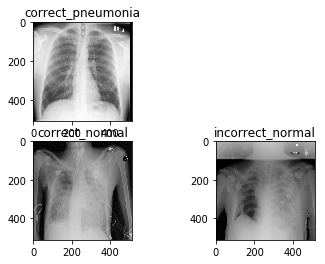

/content/SGCR/modelsupdated_model-1565230540.json
Saved model to disk


In [0]:
#----------------------------------------Main---------------------------------------------------------------------------


history = model.fit(x=train_images2, y=train_labels2,  epochs = num_epochs ,batch_size=10,
                    validation_data=[val_images2, val_labels2],
                     verbose=2 , shuffle=True, callbacks=[tensorboard])


#ploting 4 samples of each catagory : correct_pneumonia ,incorrect_pneumonia, correct_normal, incorrect_normal
#if you can not see some of these categories it means model did not predict any samples of that categories
show_samples(train_images2 ,train_imagename_label_pairs , image_dir = train_image_file_dir)


#Saving Model
dir = os.getcwd()
save_model(model)
